In [1]:
import numpy as np
import BigFunctions as BF
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import uproot as ur
#%matplotlib tk

In [2]:
#Reading the variables

input_path = "../data/bigdata_CFD_20092024_0001.root"
with ur.open(input_path) as file:
    outTree = file["DataTree"]
    label = outTree["label"].array(library = "np")
    time = outTree["time"].array(library = "np")*10**-6   #[µs]
    nrj = outTree["nrj"].array(library = "np")
    pileup = outTree["pileup"].array(library = "np")

print("Duration of the data acquisition:", max(time)*10**(-6)/3600, "hours")
print("Duration of the data acquisition:", max(time), "hours")
print("Number of events acquired:", len(label)/10**6, "million")

Duration of the data acquisition: 64.80661879629267 hours
Duration of the data acquisition: 233303827666.6536 hours
Number of events acquired: 48.889578 million


In [3]:
#To see if there was aproblem during the data acquisition
#print(time[label == 1][-50:-1]*10**(-6)/3600)
#print(time[label == 2][-100:-1]*10**(-6)/3600)

In [4]:
#Correlation

corr_t = 10*10**-3   #Correlation window
corr_mask = (time[1:]-time[:-1]<corr_t) & (label[1:] != label[:-1])

correl_both = (np.insert(corr_mask,0,False))|(np.append(corr_mask,False))
del(corr_mask)

t = time[correl_both]
l = label[correl_both]
p = pileup[correl_both]
e = nrj[correl_both]

t1 = time[correl_both & (label==1)]
t2 = time[correl_both & (label==2)]
nrj1 = nrj[correl_both & (label==1)]
nrj2 = nrj[correl_both & (label==2)]

dt2 = t2[1:]-t2[:-1]
dt1 = t1[1:]-t1[:-1]

print("Number of events after correlation:       ", len(t)/10**6, "million")
print("Dead time:                                ", min(dt2), "µs")
print("Total number of pileups:                  ", len(pileup[pileup == True]))
print("Total number of pileups after correlation:", len(p[p == True]))

Number of events after correlation:        22.2967 million
Dead time:                                 0.158599853515625 µs
Total number of pileups:                   0
Total number of pileups after correlation: 0


... After correlation only ...


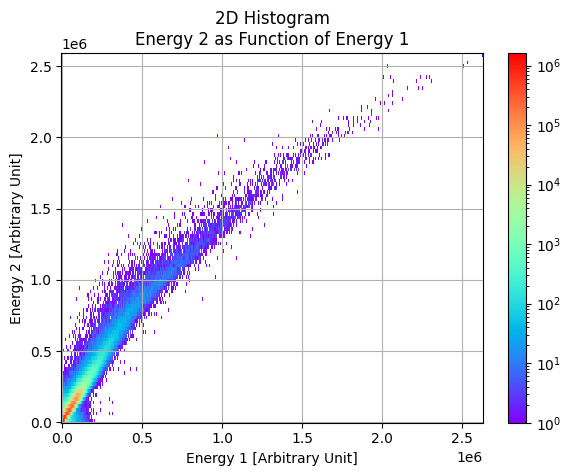

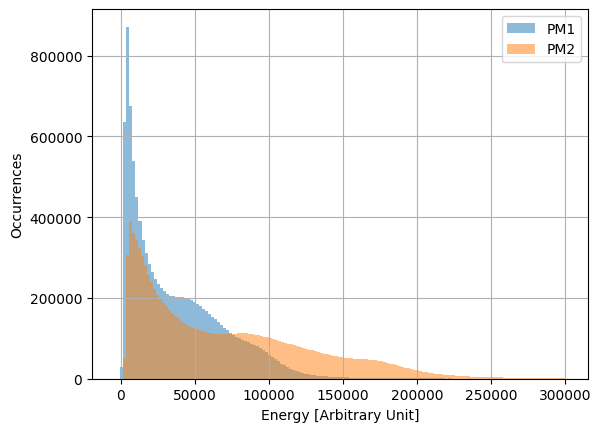

In [16]:
#Energy Analysis

#After correlation only
print('... After correlation only ...')

nrj_max = 300000

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1, nrj2, bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

plt.figure()
plt.hist(nrj1[nrj1 < nrj_max], bins = 150, alpha = 0.5, label = "PM1")
plt.hist(nrj2[nrj2 < nrj_max], bins = 150, alpha = 0.5, label = "PM2")
plt.xlabel("Energy [Arbitrary Unit]")
plt.ylabel("Occurrences")
plt.grid()
plt.legend()
plt.show()

... After correlation and cut on dt ...


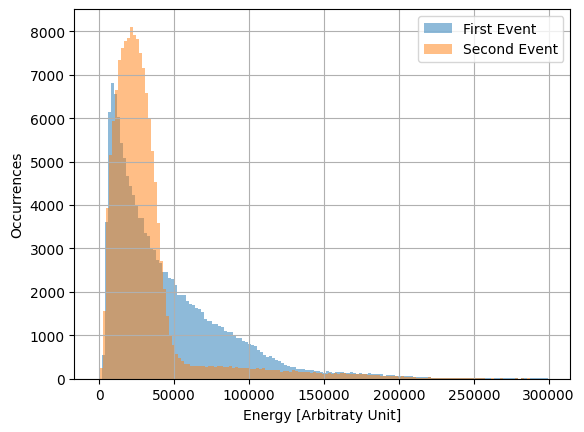

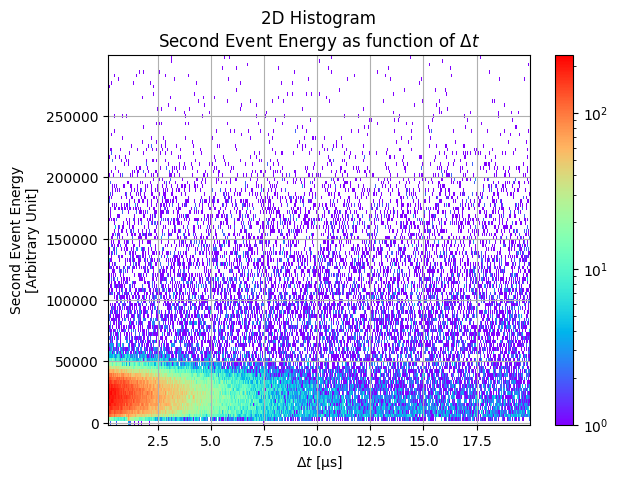

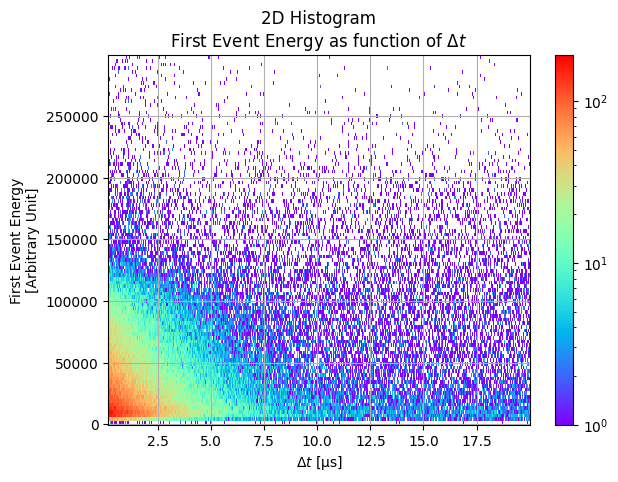

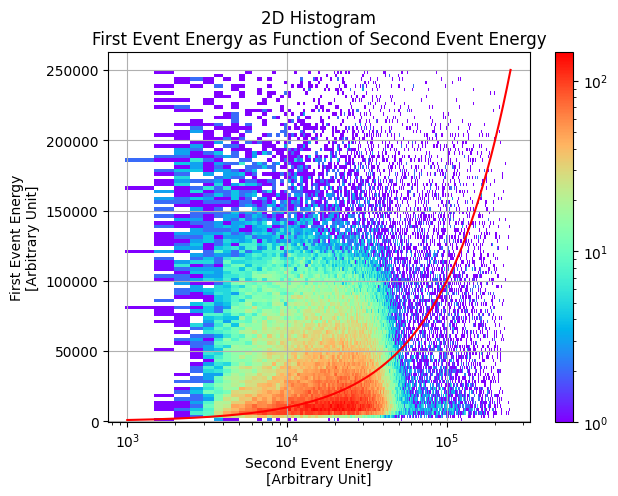

In [59]:
#After correlation and cut on dt
print('... After correlation and cut on dt ...')

dt_max = 20

#Muon and electron energy
plt.figure()
#plt.hist(nrj2[1:][(nrj2[1:]<nrj_max) & (dt2<dt_max)], bins=150, label="Second Event", alpha = 0.5)
#plt.hist(nrj2[:-1][(nrj2[:-1]<nrj_max)  & (dt2<dt_max)], bins=150, label="First Event", alpha = 0.5)
plt.hist(nrj2[(nrj2<nrj_max) & (np.append(dt2, np.nan)<dt_max)], bins=150, label="First Event", alpha = 0.5)
plt.hist(nrj2[(nrj2<nrj_max) & (np.insert(dt2, 0, np.nan)<dt_max)], bins=150, label="Second Event", alpha = 0.5)
plt.xlabel('Energy [Arbitraty Unit]')
plt.ylabel('Occurrences')
plt.legend()
plt.grid()
plt.show()

#Electron as function of dt
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(nrj2[1:]<nrj_max) & (dt2<dt_max)], 
                                 nrj2[1:][(nrj2[1:]<nrj_max) & (dt2<dt_max)],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nSecond Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon as function of dt
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(nrj2[:-1]<nrj_max) & (dt2<dt_max)], 
                                 nrj2[:-1][(nrj2[:-1]<nrj_max) & (dt2<dt_max)],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon as function of lectron

mask = nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)] < nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)]

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)],
                                 nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)],  
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as Function of Second Event Energy')
ax1.grid()
ax1.plot(np.linspace(1000, 250000, 10000),np.linspace(1000,250000, 10000),c='r')
ax1.set_xscale("log")
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

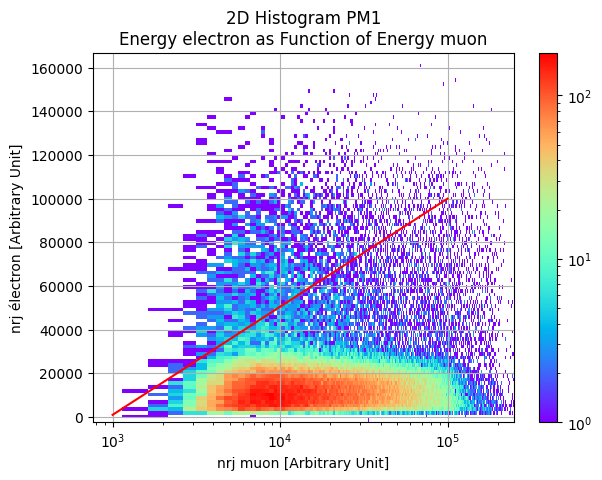

In [45]:
#fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig, (ax1) = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj2[:-1][(dt2<20) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)], nrj1[1:][(dt2<20) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)], bins =(500,100))

pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.plot([1000,100000],[1000,100000],c='r')
ax1.set_xlabel('nrj muon [Arbitrary Unit]')
ax1.set_ylabel('nrj électron [Arbitrary Unit]')
ax1.set_title('2D Histogram PM1\nEnergy electron as Function of Energy muon')
#plt.xlim(0,0.5)
ax1.grid()
ax1.set_xscale("log")
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)

plt.show()

In [49]:
#dt Analysis

dt_max = 20
dt = dt1[dt1 < dt_max]

N_bins = 45
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

#With one exponential
popt, cov = curve_fit(BF.exp1, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 400]))
N0 = popt[0]
lam = popt[1]
C = popt[2]
lam_err = cov[1,1]

chi2 = BF.chi2_norm(y, BF.exp1(x, N0, lam, C), y_err, 3)[0]
chi2_err = BF.chi2_norm(y, BF.exp1(x, N0, lam, C), y_err, 3)[1]
print("... Fit with one exponential ...")
print("chi2 = ", chi2, '+/-', chi2_err)
print('\n')

#With two exponentials
popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
N0 = popt[0]
lam1 = popt[1]
lam1_err = cov[1,1]
lam2 = popt[2]
lam2_err = cov[2,2]
CC = popt[3]

chi2 = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)

#-------------------------------------------------------

plt.figure()
plt.hist(dt2[dt2 < dt_max], bins = N_bins, alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='o', capsize=4, c='k', label = 'Data')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp1(np.linspace(min(dt), max(dt), 100), N0, lam, C), 
                     label = 'Fit with one exponential')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp2(np.linspace(min(dt), max(dt), 100), N0, lam1, lam2, CC), 
                     label = 'Fit with two exponentials')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.yscale('log')
plt.legend()
plt.show()

... Fit with one exponential ...
chi2 =  1.0838682363873486 +/- 0.21821789023599236


... Fit with two exponentials ...
chi2 =  1.08091652602346 +/- 0.2208630521496931


In [50]:
tau = 1/lam
tau_err = lam_err/lam**2

tau1 = 1/lam1
tau1_err = lam1_err/lam1**2

tau2 = 1/lam2
tau2_err = lam2_err/lam2**2

print("... Fit with one exponential ...")
print('tau = ', tau, '+/-', tau_err, 'µs')
print('\n')
print('... Fit with two exponentials ...')
print('tau1 = ', tau1, '+/-', tau1_err, 'µs')
print('tau2 = ', tau2, '+/-', tau2_err, 'µs')

... Fit with one exponential ...
tau =  2.0301597722450233 +/- 2.3703884380639982e-05 µs


... Fit with two exponentials ...
tau1 =  2.2479895535549783 +/- 0.0018217879033068955 µs
tau2 =  1.8555956474146107 +/- 0.001983879024391138 µs


In [51]:
#chi2

plt.figure()
N_bins = np.array(range(10,301))
chi2_lst = []

for n in N_bins :
    hist = np.histogram(dt, bins = n)
    x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
    y = hist[0]
    y_err = np.sqrt(y)

    popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
    N0 = popt[0]
    lam1 = popt[1]
    lam2 = popt[2]
    CC = popt[3]

    chi2 = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[0]
    chi2_err = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[1]

    chi2_lst.append(chi2)

    plt.errorbar(n, chi2, yerr = chi2_err, linestyle = 'None', fmt='o', capsize=4, c='k')
    plt.scatter(n, chi2, c='k')

plt.xlabel("Number of bins")
plt.ylabel("Reduced $\chi^2$")
plt.show()
    

In [52]:
chi2_lst = np.array(chi2_lst)
print(min(np.abs(1-chi2_lst))+1)

print(np.argwhere(chi2_lst == min(np.abs(1-chi2_lst))+1))

print(chi2_lst[35])
print(N_bins[35])

1.0017544702978989
[]
1.08091652602346
45
